# Modelos de Crescimento Econômico: **Bases de Dados** 

Antes de entrarmos nos modelos, é essencial conhecermos algumas fontes de dados econômicos para conseguirmos ter acesso às informações que nos interessam.

----

## *Setup*

In [1]:
## Já instalando bibliotecas necessárias
from IPython.display import clear_output # limpa o output de uma célula
!pip install ipeadatapy  # dados do ipeadata
# Link: http://www.luanborelli.net/ipeadatapy/docs/usage/quickstart/extraction.html#extracting-one-single-time-series

!pip install pybacen  # dados do Banco Central (bacen)
# Link: https://pythonrepo.com/repo/RPCastro07-pybacen-python-third-party-apis-wrappers

!pip install wbgapi  # dados do Banco Mundial (World Bank)
# Link: https://pypi.org/project/wbgapi/

# Mapas
!pip install geopandas
!pip install mapclassify
!pip install geobr

clear_output()  # limpando o texto

In [2]:
## Importando o que for necessário
# Manipulação de Dados
import pandas as pd
import numpy as np

# Estatística e Modelos
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms

# Gráficos
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick  # formatação dos números dos eixos dos gráficos
import matplotlib as mpl
import seaborn as sns

# Mapas
import geopandas as gpd
import mapclassify
import geobr

# Estilo dos gráficos
from matplotlib import style
style.use("ggplot")

# Coleta de dados
import ipeadatapy  # ipeadata
from pybacen.bacen import time_series  # banco central
import wbgapi as wb  # banco mundial

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Talvez o trio de variáveis econômicas mais estudas sejam o **PIB**, a **taxa de juros** e a **inflação**. 

Vamos ver como pegar dados de cada uma delas de três fontes diferentes!

## Penn World Table

Link de acesso: https://www.rug.nl/ggdc/productivity/pwt/?lang=en

Variável de Interesse: PIB e PIB per Capita

### Leitura dos Dados

In [4]:
## Lendo os dados
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/Disciplina 3 - Crescimento Econômico/Dados/"
# sCaminho = '/content/drive/MyDrive/Projetos/IDP/MBA/SetorPublicoIII/'
sArquivo = "pwt100.dta"

## Lendo o DataFrame
dfPWT = pd.read_stata(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {dfPWT.shape[0]}; Colunas: {dfPWT.shape[1]}")

Linhas: 12810; Colunas: 52


In [5]:
## Vendo a descrição das variáveis (só funciona com arquivos .dta)
# Lendo novamente a base, mas agora com iterator, o que retorna um objeto do tipo StataReader
stata_reader = pd.read_stata(f"{sCaminho}{sArquivo}", iterator=True)

# Pegando as descrições das variáveis
descricoes = stata_reader.variable_labels()
descricoes

# Como podemos ver, há UM MONTE de variáveis que podemos usar; se quisermoes ver o PIB em termos reais
# e respeitando a paridade do poder de compra entre países (ou seja, a diferença entre custos de vida),
# por exemplo, podemos olhar para a variável rgdpe (lado da despesa) ou rgdpo (lado da produção)

{'avh': 'Average annual hours worked by persons engaged (source: The Conference Board)',
 'ccon': 'Real consumption of households and government, at current PPPs (in mil. 2017US$)',
 'cda': 'Real domestic absorption, see note cda',
 'cgdpe': 'Expenditure-side real GDP at current PPPs (in mil. 2017US$)',
 'cgdpo': 'Output-side real GDP at current PPPs (in mil. 2017US$)',
 'ck': 'Capital services levels at current PPPs (USA=1)',
 'cn': 'Capital stock at current PPPs (in mil. 2017US$)',
 'cor_exp': 'Correlation between expenditure shares, see note cor_exp',
 'country': 'Country name',
 'countrycode': '3-letter ISO country code',
 'csh_c': 'Share of household consumption at current PPPs',
 'csh_g': 'Share of government consumption at current PPPs',
 'csh_i': 'Share of gross capital formation at current PPPs',
 'csh_m': 'Share of merchandise imports at current PPPs',
 'csh_r': 'Share of residual trade and GDP statistical discrepancy at current PPPs',
 'csh_x': 'Share of merchandise exports 

In [6]:
## Vendo as primeiras linha da base
dfPWT.head(5)

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,ccon,cda,cgdpe,cgdpo,cn,ck,ctfp,cwtfp,rgdpna,rconna,rdana,rnna,rkna,rtfpna,rwtfpna,labsh,irr,delta,xr,pl_con,pl_da,pl_gdpo,i_cig,i_xm,i_xr,i_outlier,i_irr,cor_exp,statcap,csh_c,csh_i,csh_g,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,Aruban Guilder,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,Aruban Guilder,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,Aruban Guilder,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,Aruban Guilder,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,Aruban Guilder,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
## Vendo os últimos dados do Brasil!
dfPWT.query("countrycode == 'BRA'").tail(5)

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,ccon,cda,cgdpe,cgdpo,cn,ck,ctfp,cwtfp,rgdpna,rconna,rdana,rnna,rkna,rtfpna,rwtfpna,labsh,irr,delta,xr,pl_con,pl_da,pl_gdpo,i_cig,i_xm,i_xr,i_outlier,i_irr,cor_exp,statcap,csh_c,csh_i,csh_g,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
1745,BRA,Brazil,Brazilian Real,2015,3082948.00,3082939.0,204.471769,92.447227,1722.875805,2.813660,2508924.50,3107361.25,3071934.25,3068602.50,13952505.0,0.183316,0.542436,0.529600,3029301.75,2484903.5,3050153.25,13283081.0,0.996534,1.032599,1.046615,0.581198,0.093213,0.050412,3.326904,0.601533,0.586670,0.587307,ICP PPP timeseries: benchmark or interpolated,Benchmark,Market-based,Regular,Regular,0.778776,72.222233,0.641508,0.195019,0.176104,0.120297,-0.132928,1.291916e-16,0.585604,0.524357,0.659558,0.629805,0.620915,0.344669,0.558301
1746,BRA,Brazil,Brazilian Real,2016,2939545.50,2931514.0,206.163053,90.626472,1714.675028,2.880657,2418792.50,2913414.25,2925105.25,2918882.00,13505046.0,0.174535,0.523142,0.504442,2930064.50,2413167.5,2905008.75,13382091.0,0.996943,0.999256,0.997294,0.580193,0.095125,0.049494,3.491313,0.628293,0.613890,0.615199,ICP PPP timeseries: benchmark or interpolated,Benchmark,Market-based,Regular,Regular,0.768470,76.666667,0.642424,0.169456,0.186247,0.123180,-0.121306,0.000000e+00,0.615286,0.543460,0.673155,0.622626,0.611971,0.355176,0.567208
1747,BRA,Brazil,Brazilian Real,2017,2970570.75,2968825.5,207.833823,90.501389,1709.594351,2.949250,2445436.00,2949229.00,2970570.75,2968825.50,13467872.0,0.170891,0.523363,0.500118,2968825.50,2445436.0,2949229.00,13467872.0,1.000000,1.000000,1.000000,0.577995,0.101184,0.048663,3.191389,0.714072,0.694425,0.694833,Benchmark,Benchmark,Market-based,Regular,Regular,0.768093,74.444433,0.635448,0.169694,0.188257,0.137065,-0.130464,-1.128691e-16,0.705088,0.599058,0.744396,0.634841,0.628697,0.397886,0.645436
1748,BRA,Brazil,Brazilian Real,2018,3057741.50,3042121.5,209.469323,92.090942,1706.057169,3.019475,2531137.25,3043804.00,3055464.50,3043949.75,13554706.0,0.169199,0.518049,0.498081,3007931.50,2527240.5,3045317.50,13584285.0,1.006451,0.987977,1.006903,0.577995,0.099338,0.048185,3.653825,0.631602,0.617081,0.619415,Extrapolated,Benchmark,Market-based,Regular,Regular,NaN,84.444433,0.645965,0.168422,0.185565,0.140989,-0.140941,1.234868e-16,0.620447,0.545390,0.670433,0.654160,0.637610,0.368352,0.562399
1749,BRA,Brazil,Brazilian Real,2019,3089273.50,3080048.5,211.049527,93.956825,1707.795058,3.091373,2566911.00,3094944.50,3084710.00,3079724.50,13677290.0,0.165538,0.506780,0.489814,3042119.00,2559893.0,3096299.75,13716485.0,1.014482,0.970512,0.994361,0.577995,0.099884,0.047845,3.927342,0.613449,0.599018,0.599987,Extrapolated,Extrapolated,Market-based,Regular,Regular,NaN,84.444433,0.649945,0.171455,0.183542,0.132833,-0.137775,1.377994e-07,0.599450,0.528862,0.663023,0.646922,0.638165,0.357599,0.545481


### Variáveis Absolutas e Per Capita

Aqui, a ideia é ver a diferença (em termos de análise) quando se analisa a trajetória de uma variável como o PIB em termos absolutos ou per capita (ou seja, dividindo pela população).

A ideia de dividir o PIB pela população é ter uma ideia, em termos **médios** [1], de como medir a qualidade de vida de um país.

[1]: Na verdade, a análise per capita esconde uma série de coisas relevante para a qualidade de vida e a "felicidade" de uma população, como a desigualdade, poluição, etc. Para uma boa discussão, ver o livro [*Economia da Felicidade*](https://www.amazon.com.br/dp/B08Z4GZBV7/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1) de Carlos Alberto Ramos.

In [8]:
## Vendo a trajetória do PIB real do Brasil, levando em consideração o custo de vida
# Pegando os dados dos últimos 30 anos
dfPIB_Brasil = dfPWT.query("countrycode == 'BRA' & year >= 1990")[['year', 'rgdpo', 'pop']]

In [9]:
## Para nos concentrarmos na tendência, podemos fazer 1990=100
# Pegando o PIB de 1990
nPIB1990 = float(dfPIB_Brasil.query('year == 1990')['rgdpo'])

## Criando a coluna com os índices
dfPIB_Brasil['rgdpo_100'] = np.where(
    dfPIB_Brasil['year'] == 1990,
    100,
    dfPIB_Brasil['rgdpo'] / nPIB1990 * 100
)

dfPIB_Brasil.head(5)

## O que basicamente isso nos diz é que, em relação a 1990, o PIB de 1991 é 9% maior
##, o PIB de 1992 12,2% maior...

,year,rgdpo,pop,rgdpo_100
1720,1990,954572.000,149.003223,100.000000
1721,1991,1041851.125,151.648011,109.143272
1722,1992,1071128.500,154.259380,112.210342
1723,1993,1155152.375,156.849078,121.012589
1724,1994,1300092.750,159.432716,136.196411


Text(0.5, 1.0, 'PIB do Brasil ao longo do tempo')

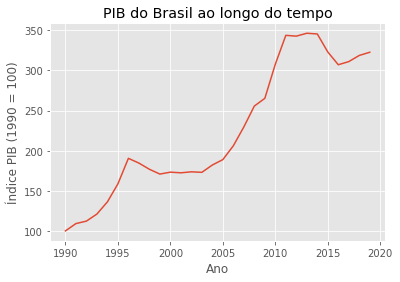

In [10]:
## Plottando
# Tornando o ano como index
dfPIB_Brasil.set_index('year', inplace=True)

# Dados
dfPIB_Brasil["rgdpo_100"].plot()

# Títulos
plt.xlabel("Ano")
plt.ylabel("Índice PIB (1990 = 100)")
plt.title("PIB do Brasil ao longo do tempo")

In [11]:
## E em termos per capita?
# Dividindo PIB pela população
dfPIB_Brasil["pib_per_capita"] = dfPIB_Brasil["rgdpo"] / dfPIB_Brasil["pop"]

# Valor do PIB per Capita em 1990
nPIBCapita1990 = float(dfPIB_Brasil.query('year == 1990')['pib_per_capita'])

## Criando a coluna com os índices
dfPIB_Brasil['pib_per_capita_100'] = np.where(
    dfPIB_Brasil.index == 1990,
    100,
    dfPIB_Brasil['pib_per_capita'] / nPIBCapita1990 * 100
)

dfPIB_Brasil.head(5)

,rgdpo,pop,rgdpo_100,pib_per_capita,pib_per_capita_100
year,,,,,
1990,954572.000,149.003223,100.000000,6406.384914,100.000000
1991,1041851.125,151.648011,109.143272,6870.193141,107.239781
1992,1071128.500,154.259380,112.210342,6943.684721,108.386942
1993,1155152.375,156.849078,121.012589,7364.738064,114.959344
1994,1300092.750,159.432716,136.196411,8154.491641,127.286945


Text(0.5, 1.0, 'PIB per Capita do Brasil ao longo do tempo')

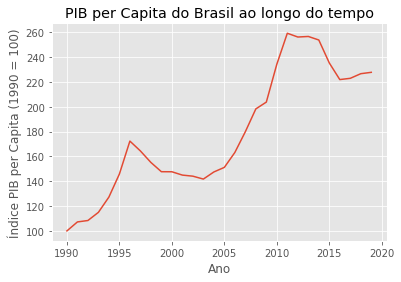

In [12]:
## Plottando
# Dados
dfPIB_Brasil["pib_per_capita_100"].plot()

# Títulos
plt.xlabel("Ano")
plt.ylabel("Índice PIB per Capita (1990 = 100)")
plt.title("PIB per Capita do Brasil ao longo do tempo")

In [13]:
## Como colocamos na mesma base, podemos inclusive comparar a trajetória dos PIBs
## Uma coisa muito dita na mídia é que 2010 foi uma década perdida... vamos aos dados!

# Dados apenas a partir de 2010
dfPIB_Brasil2010 = dfPIB_Brasil.tail(10)

# Valor do PIB em 2010
nPIB2010 = float(dfPIB_Brasil2010['rgdpo'].iloc[0])

## Criando a coluna com os índices
dfPIB_Brasil2010['rgdpo_100'] = np.where(
    dfPIB_Brasil2010.index == 1990,
    100,
    dfPIB_Brasil2010['rgdpo'] / nPIB2010 * 100
)

# Valor do PIB per Capita em 2010
nPIBCapita2010 = float(dfPIB_Brasil2010['pib_per_capita'].iloc[0])

## Criando a coluna com os índices
dfPIB_Brasil2010['pib_per_capita_100'] = np.where(
    dfPIB_Brasil2010.index == 1990,
    100,
    dfPIB_Brasil2010['pib_per_capita'] / nPIBCapita2010 * 100
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



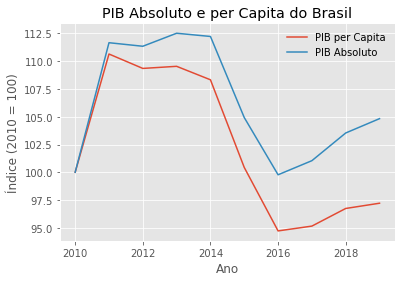

In [14]:
## Plottando
dfPIB_Brasil2010[["pib_per_capita_100", "rgdpo_100"]].plot()

# Títulos
plt.xlabel("Ano")
plt.ylabel("Índice (2010 = 100)")
plt.title("PIB Absoluto e per Capita do Brasil")

# Legenda
plt.legend(["PIB per Capita", "PIB Absoluto"], frameon=False, facecolor=None)

## Como vemos, o PIB brasileiro cresceu ao longo da década (2019 > 2010), mas o PIB per capita, não,
## o que é um indício da estagnação econômica sentida pela população

## Banco Central

Link de acesso ao *Sistema Gerador de Séries Temporais* (SGS): https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries

Variável de Interesse: Taxa de Juros

### Taxas de Juros

In [47]:
## Vamos analisar o comportamento da Selic - a taxa básica de juros de curto prazo da economia
## Ela serve como base para todas as outras taxas de juros, e, por isso, é fundamental para entender o ambiente macroeconômico

## Para isso, vamos utilizar o método time_series da biblioteca pybacen.bacen; o código da série é 1178
# Podemos estipular também os parâmetros start e end, que delimitariam as datas de começo e fim dos dados
# as_index: data como index, não coluna
dfSelic = time_series.read_time_series(bacen_code=1178, as_index=True)

dfSelic

,valor
date,
1986-06-04,17.80
1986-06-05,18.50
1986-06-06,18.31
1986-06-09,18.76
1986-06-10,18.40
...,...
2021-12-02,7.65
2021-12-03,7.65
2021-12-06,7.65


Text(0.5, 1.0, 'Taxa de Juros da Economia Brasileira')

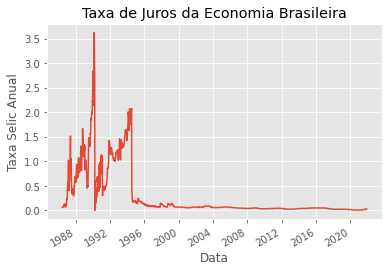

In [16]:
## Plottando
dfSelic.plot(legend=None)

# Títulos
plt.xlabel("Data")
plt.ylabel("Taxa Selic Anual")
plt.title("Taxa de Juros da Economia Brasileira")

# Note que esses valores altos não é um erro dos dados: antes do Plano Real, a selic realmente ficou em patamares gigantescos para coibir a hiperinflação
# A lógica por trás é: quanto maior os juros, mais caro o crédito e mais vale a pena poupar, o que reduz o consumo e a demanda.
# Pela Lei da Oferta e da Demanda, uma menor demanda, dada a mesma oferta, faz com que caiam os preços, o que reduz a inflação.
# Além disso, juros maiores encarecem a dívida pública e coibiem gastos e investimentos do governo, reduzindo a demanda estatal.

# O porquê de a hiperinflação persistir é tema de (literalmente) um curso por si só, mas aqui ficam dois breves porquês:
# 1. A inflação não era só de demanda, possuindo um componente inercial muito forte ("os preços sobem hoje porque subiram ontem")
# 2. A inflação não era apenas doméstica, tendo muitos componentes vindos de fora (um pouco o que acontece hoje com semicondutores, preço de combustíveis...)

Text(0.5, 1.0, 'Taxa de Juros da Economia Brasileira')

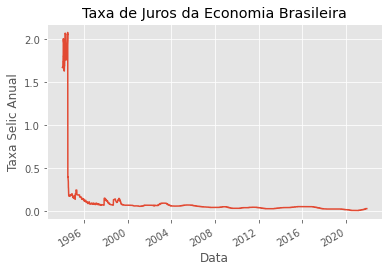

In [17]:
## Para ver melhor o gráfico, vamos restringir apenas a análise a partir de 1994 (Plano Real)
## Plottando
dfSelic.query("date >= '1994-01-01'").plot(legend=None)

# Títulos
plt.xlabel("Data")
plt.ylabel("Taxa Selic Anual")
plt.title("Taxa de Juros da Economia Brasileira")

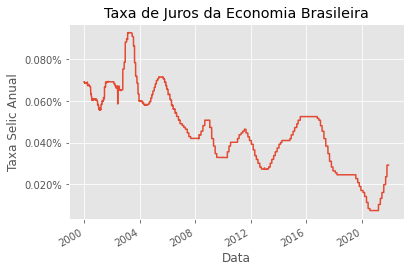

In [18]:
## Plottando apenas século XXI (pós hiperinflação)
ax = dfSelic.query("date >= '2000-01-01'").plot(legend=None)

# Títulos
plt.xlabel("Data")
plt.ylabel("Taxa Selic Anual")
plt.title("Taxa de Juros da Economia Brasileira")

# Colocando valores do eixo y como percentuais
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

### Curiosidade: Relação entre a Variação das Exportações (Commodities) e a Variação do Produto Brasileiro

In [19]:
## Vamos ver como a variação das exportações e a variação do produto brasileiro são parecidas
# Pegando os valores brutos das exportações (23471)
dfExp = time_series.read_time_series(bacen_code=23471, as_index=True, start="1999-01-01")

# Pegando os valores brutos do PIB (7324)
dfPIB = time_series.read_time_series(bacen_code=7324, as_index=True, start="1999-01-01")

# Concatenando os dois dfs
dfExpPIB = dfPIB.merge(dfExp, how="inner", left_index=True, right_index=True)

# Renomeando as colunas
dfExpPIB.rename(columns={'valor_x':'PIB', 'valor_y':'Exp'}, inplace=True)

# Vendo primeiros valores
dfExpPIB.head(5)

,PIB,Exp
date,,
1999-01-01,599289.51,47598.2
2000-01-01,655707.37,54617.8
2001-01-01,559562.59,57792.6
2002-01-01,508101.18,59941.3
2003-01-01,559465.40,72647.9


In [20]:
# Pegando apenas as variações percentuais
dfExpPIB_Var = dfExpPIB.pct_change()
dfExpPIB_Var.head(5)

,PIB,Exp
date,,
1999-01-01,NaN,NaN
2000-01-01,0.094141,0.147476
2001-01-01,-0.146628,0.058128
2002-01-01,-0.091967,0.037180
2003-01-01,0.101091,0.211984


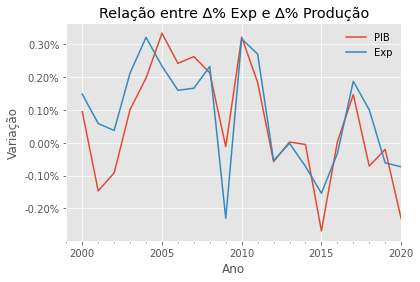

In [21]:
## Plottando
ax = dfExpPIB_Var.plot()

# Títulos
plt.xlabel("Ano")
plt.ylabel("Variação")
plt.title("Relação entre ∆% Exp e ∆% Produção")

# Legenda
plt.legend(frameon=False, facecolor=None)

# Colocando valores do eixo y como percentuais
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Como o Brasil se torna, principalmente no século XXI, um país voltada para a exportação de produtos agrícolas, o crescimento do PIB geralmente dependem das exportações de commodities que, por sua vez, dependem dos preços internacionais.

E será que as séries são cointegradas? Fica ai a pergunta!

Se alguém quiser fazer, vejam a aula do dia **26 de outubro** e lembrem-se que, para testar cointegração, ambas as séries devem ser integradas de ordem 1 (é necessário tirar a primeira diferença).

## Ipeadata

Link de acesso: http://www.ipeadata.gov.br/Default.aspx

Variável de Interesse: Taxa de Inflação, medida pelo Índice de Preços ao Consumidor Amplo (IPCA)

In [22]:
## Vamos usar a biblioteca ipeadatapy!
# Listando as séries disponíveis
dfSeriesIpeadata = ipeadatapy.list_series()
dfSeriesIpeadata

,CODE,NAME
0,ABATE_ABPEAV,Abate - aves - peso das carcaças
1,ABATE_ABPEBV,Abate - bovinos - peso das carcaças
2,ABATE_ABPESU,Abate - suínos - peso das carcaças
3,ABATE_ABQUAV,Abate - aves - quantidade
4,ABATE_ABQUBV,Abate - bovinos - quantidade
...,...,...
8880,PIBVRAE,PIB Estadual - valor adicionado a preços constantes - var.(%)
8881,VPRODPIN,Valor da produção - Indústria - Total
8882,COVID19_CASOS,Casos de COVID19 no dia
8883,COVID19_CASOSACUM,"Casos de COVID19, acumulados até o dia"


In [23]:
## Vendo séries relacionados ao IPCA
dfSeriesIpeadata[dfSeriesIpeadata['NAME'].str.contains("IPCA")]

,CODE,NAME
4554,BM12_IPCA2012,IPCA - núcleo médias aparadas com suavização - taxa de variação
4555,BM12_IPCA20N12,IPCA - núcleo médias aparadas sem suavização - taxa de variação
4556,BM12_IPCACOM12,IPCA - preços livres - comercializáveis - taxa de variação
4557,BM12_IPCAEXC12,IPCA - núcleo por exclusão - sem monitorados e alimentos no domicílio - taxa de variação
4558,BM12_IPCAEXCEX212,IPCA - núcleo por exclusão - EX1 - taxa de variação
4559,BM12_IPCAEXP1212,Expectativa média de Inflação - IPCA - taxa acumulada para os próximos doze meses
4560,BM12_IPCAEXP612,Expectativa média de Inflação - IPCA - taxa anualizada para os próximos seis meses
4561,BM12_IPCANCOM12,IPCA - preços livres - não comercializáveis - taxa de variação
4562,BM12_IPCAPL12,IPCA - preços livres - taxa de variação
4563,BM12_IPCAPLBD12,IPCA - preços livres - bens duráveis - taxa de variação


In [24]:
## Vamos pegar o IPCA total por mês
# Atenção: os valores para cada mês estão anualizados, ou seja, dizem qual seria a inflação de um ano
# caso a taxa do mês se repetisse por 12 meses consecutivos
# Link: http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=38391
dfIPCA = ipeadatapy.timeseries('PAN12_IPCAG12')
dfIPCA.tail(5)

,YEAR,DAY,MONTH,CODE,RAW DATE,VALUE ((% a.a.))
DATE,,,,,,
2021-06-01,2021,1,6,PAN12_IPCAG12,2021-06-01T00:00:00-03:00,6.548782
2021-07-01,2021,1,7,PAN12_IPCAG12,2021-07-01T00:00:00-03:00,12.147729
2021-08-01,2021,1,8,PAN12_IPCAG12,2021-08-01T00:00:00-03:00,10.954166
2021-09-01,2021,1,9,PAN12_IPCAG12,2021-09-01T00:00:00-03:00,14.842843
2021-10-01,2021,1,10,PAN12_IPCAG12,2021-10-01T00:00:00-03:00,16.074844


In [25]:
## Vamos deixar os dados mais bonitinhos
# Renomeando a coluna relevante
dfIPCA.rename(columns={"VALUE ((% a.a.))": "IPCA"}, inplace=True)

# Deixando apenas ela no DataFrame e usando [[]] para manter como dataframe
# Usar apenas um colchete ( [] ) retornaria uma série
dfIPCA = dfIPCA[["IPCA"]]
dfIPCA.tail(5)

,IPCA
DATE,
2021-06-01,6.548782
2021-07-01,12.147729
2021-08-01,10.954166
2021-09-01,14.842843
2021-10-01,16.074844


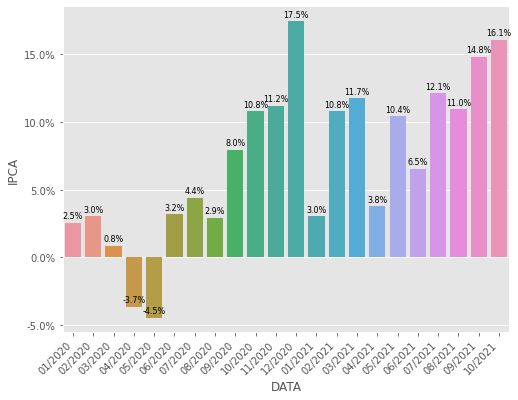

In [26]:
## Plottando de um jeito diferente
# EM GERAL, se plotta séries de tempo usando linhas, mas vamos plottar um gráfico de barras usando o seaborn para variar um pouco

# Coluna auxiliar com as datas
dfIPCA["DATA"] = dfIPCA.index

## Objeto gráfico
plt.figure(figsize=(8, 6))

## Criando o objeto do seaborn
ax = sns.barplot(data=dfIPCA.query("DATA >= '2020-01-01'"), x="DATA", y="IPCA")

## Arrumando as datas do eixo x
vDatas = dfIPCA.query("DATA >= '2020-01-01'")["DATA"].dt.strftime('%m/%Y')
ax.set_xticklabels(labels=vDatas, rotation=45, ha='right')

# Colocando valores do eixo y como percentuais
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Anotando barras
for p in ax.patches:
    ax.annotate(format(p.get_height() / 100, '.1%'),  # plottando como valores percentuais
                   (p.get_x() + p.get_width() / 2., p.get_height() + 0.5),  # plottando no centro horizontal da barra e na extremidade externa
                   ha = 'center', va = 'center',
                   fontsize=8)

plt.show()

Pontos interessantes: deflação no começo da pandemia e aceleração da inflação neste ano.

Mais informações sobre a seaborn: https://seaborn.pydata.org/tutorial.html

## Banco Mundial / World Bank

In [27]:
## Vamos usar a biblioteca do World Bank, wbgapi (importada como wb)
# Vendo as bases disponíveis
wb.source.info()

id,name,code,concepts,lastupdated
1,Doing Business,DBS,3,2021-08-18
2,World Development Indicators,WDI,3,2021-11-23
3,Worldwide Governance Indicators,WGI,3,2021-09-27
5,Subnational Malnutrition Database,SNM,3,2016-03-21
6,International Debt Statistics,IDS,4,2021-10-10
11,Africa Development Indicators,ADI,3,2013-02-22
12,Education Statistics,EDS,3,2020-12-20
13,Enterprise Surveys,ESY,3,2021-04-02
14,Gender Statistics,GDS,3,2021-09-27
15,Global Economic Monitor,GEM,3,2020-07-27


In [28]:
# Vendo, por exemplo, séries sobre pobreza
# q: query
wb.series.info(q='poverty')

id,value
SH.UHC.NOP1.CG,Increase in poverty gap at $1.90 ($ 2011 PPP) poverty line due to out-of-pocket health care expenditure (USD)
SH.UHC.NOP1.TO,Number of people pushed below the $1.90 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure
SH.UHC.NOP1.ZG,Increase in poverty gap at $1.90 ($ 2011 PPP) poverty line due to out-of-pocket health care expenditure (% of poverty line)
SH.UHC.NOP1.ZS,Proportion of population pushed below the $1.90 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure (%)
SH.UHC.NOP2.CG,Increase in poverty gap at $3.20 ($ 2011 PPP) poverty line due to out-of-pocket health care expenditure (USD)
SH.UHC.NOP2.TO,Number of people pushed below the $3.20 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure
SH.UHC.NOP2.ZG,Increase in poverty gap at $3.20 ($ 2011 PPP) poverty line due to out-of-pocket health care expenditure (% of poverty line)
SH.UHC.NOP2.ZS,Proportion of population pushed below the $3.20 ($ 2011 PPP) poverty line by out-of-pocket health care expenditure (%)
SI.POV.DDAY,Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)
SI.POV.GAPS,Poverty gap at $1.90 a day (2011 PPP) (%)


In [29]:
## Coletando os dados mais recente (mrnev=1) da % de pobreza
dfPobreza = wb.data.DataFrame("SI.POV.UMIC", mrnev=1)
print(f"Número de países com dados disponíveis: {dfPobreza.shape[0]}")
dfPobreza.head()

Número de países com dados disponíveis: 181


,SI.POV.UMIC
economy,
AGO,88.5
ALB,33.8
ARE,0.1
ARG,14.4
ARM,44.0


In [30]:
## Usando o geopandas para pegar as latitudes e formas dos países
dfPaises = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

## Tirando antarctica
dfPaises = dfPaises[dfPaises.name != "Antarctica"]

print(f"Número de países com dados disponíveis: {dfPaises.shape[0]}")
dfPaises.head(2)

## Importante: dfPaises é um tipo especial de DataFrame, chamado GeoDataFrame

Número de países com dados disponíveis: 176


/usr/local/lib/python3.7/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/usr/local/lib/python3.7/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000 -16.55522, 179.36414 -16.80135, 178.72506 -17.01204, 178.59684 -16.63915, 179.09661 -16.43398, 179.41351 -16.37905, 180.00000 -16.06713)), ((178.12557 -17.50481, 178.37360 -17.33992, 178.71806 -17.62846, 178.55271 -18.15059, 177.93266 -18.28799, 177.38146 -18.16432, 177.28504 -17.72465, 177.67087 -17.38114, 178.12557 -17.50481)), ((-179.79332 -16.02088, -179.91737 -16.50178, -180.00000 -16.55522, -180.00000 -16.06713, -179.79332 -16.02088)))"
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982, 37.69869 -3.09699, 37.76690 -3.67712, 39.20222 -4.67677, 38.74054 -5.90895, 38.79977 -6.47566, 39.44000 -6.84000, 39.47000 -7.10000, 39.19469 -7.70390, 39.25203 -8.00781, 39.18652 -8.48551, 39.53574 -9.11237, 39.94960 -10.09840, 40.31659 -10.31710, 40.31659 -10.31710, 39.52100 -10.89688, 38.42756 -11.28520, 37.82764 -11.26879, 37.47129 -11.56876, 36.77515 -11.59454, 36.51408 -11.72094, 35.31240 -11.43915, 34.55999 -11.52002, 34.28000 -10.16000, 33.94084 -9.69367, 33.73972 -9.41715, 32.75938 -9.23060, 32.19186 -8.93036, 31.55635 -8.76205, 31.15775 -8.59458, 30.74001 -8.34001, 30.74002 -8.34001, 30.20000 -7.07998, 29.62003 -6.52002, 29.41999 -5.94000, 29.51999 -5.41998, 29.34000 -4.49998, 29.75351 -4.45239, 30.11632 -4.09012, 30.50554 -3.56858, 30.75224 -3.35931, 30.74301 -3.03431, 30.52766 -2.80762, 30.46967 -2.41385, 30.46967 -2.41383, 30.75831 -2.28725, 30.81613 -1.69891, 30.41910 -1.13466, 30.76986 -1.01455, 31.86617 -1.02736, 33.90371 -0.95000))"


In [31]:
## Modificando dfPobreza para permitir o join
# Criando coluna com as siglas dos países (estão no index)
dfPobreza['iso_a3'] = dfPobreza.index

# Renomeando a coluna
dfPobreza.rename(columns={"SI.POV.UMIC":"Pobreza (%)"}, inplace=True)

In [32]:
## Vamos unir os dois datasets para termos os dados georreferenciados de pobreza
dfPaises1 = dfPaises.merge(dfPobreza, on='iso_a3', how="left")
dfPaises1.head(2)

## Veja que, apesar de termos dados de 156 países, nosso df final acaba com 139 linhas
## Isso provavelmente se deve ao fato de algumas siglas serem diferentes o que, em um trabalho mais profundo, exigiria algumas correções

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Pobreza (%)
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000 -16.55522, 179.36414 -16.80135, 178.72506 -17.01204, 178.59684 -16.63915, 179.09661 -16.43398, 179.41351 -16.37905, 180.00000 -16.06713)), ((178.12557 -17.50481, 178.37360 -17.33992, 178.71806 -17.62846, 178.55271 -18.15059, 177.93266 -18.28799, 177.38146 -18.16432, 177.28504 -17.72465, 177.67087 -17.38114, 178.12557 -17.50481)), ((-179.79332 -16.02088, -179.91737 -16.50178, -180.00000 -16.55522, -180.00000 -16.06713, -179.79332 -16.02088)))",35.8
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982, 37.69869 -3.09699, 37.76690 -3.67712, 39.20222 -4.67677, 38.74054 -5.90895, 38.79977 -6.47566, 39.44000 -6.84000, 39.47000 -7.10000, 39.19469 -7.70390, 39.25203 -8.00781, 39.18652 -8.48551, 39.53574 -9.11237, 39.94960 -10.09840, 40.31659 -10.31710, 40.31659 -10.31710, 39.52100 -10.89688, 38.42756 -11.28520, 37.82764 -11.26879, 37.47129 -11.56876, 36.77515 -11.59454, 36.51408 -11.72094, 35.31240 -11.43915, 34.55999 -11.52002, 34.28000 -10.16000, 33.94084 -9.69367, 33.73972 -9.41715, 32.75938 -9.23060, 32.19186 -8.93036, 31.55635 -8.76205, 31.15775 -8.59458, 30.74001 -8.34001, 30.74002 -8.34001, 30.20000 -7.07998, 29.62003 -6.52002, 29.41999 -5.94000, 29.51999 -5.41998, 29.34000 -4.49998, 29.75351 -4.45239, 30.11632 -4.09012, 30.50554 -3.56858, 30.75224 -3.35931, 30.74301 -3.03431, 30.52766 -2.80762, 30.46967 -2.41385, 30.46967 -2.41383, 30.75831 -2.28725, 30.81613 -1.69891, 30.41910 -1.13466, 30.76986 -1.01455, 31.86617 -1.02736, 33.90371 -0.95000))",91.8


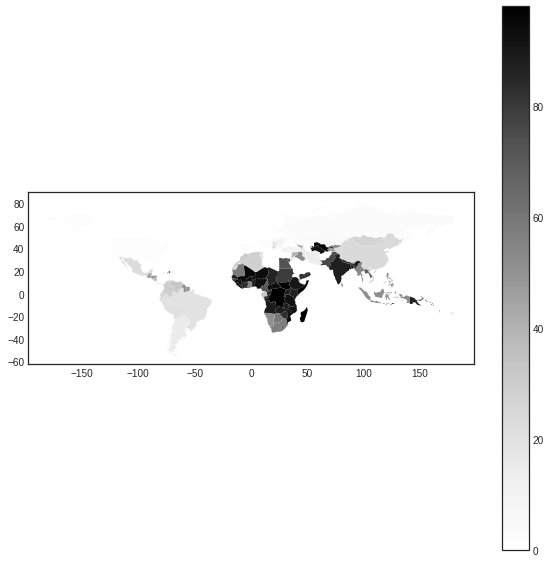

In [33]:
#### Plottando um mapa!
style.use('seaborn-white')

## Objeto gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

## Dados
dfPaises1.plot(column='Pobreza (%)', ax=ax, legend=True)

# Limpando mensagens de avisos de erros futuros no pacote
clear_output()

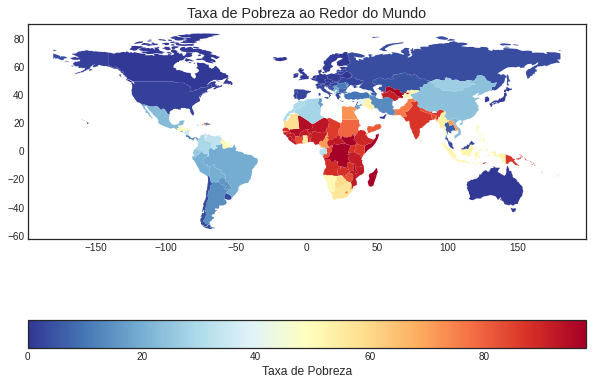

In [34]:
#### Muitas coisas a melhorar: cores, tamanho da barra de cor, orientação da barra, legenda...

## Objeto gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

## Dados
# cmap: mapa de cor
# legend_kwds: plottando a barra de forma horizontal e com legenda
dfPaises1.plot(column='Pobreza (%)', 
               ax=ax, 
               legend=True,
               cmap='RdYlBu_r',
               legend_kwds={'label': "Taxa de Pobreza",
                            'orientation': "horizontal"})

## Título
plt.title("Taxa de Pobreza ao Redor do Mundo")

# Limpando mensagens de avisos de erros futuros no pacote
clear_output()

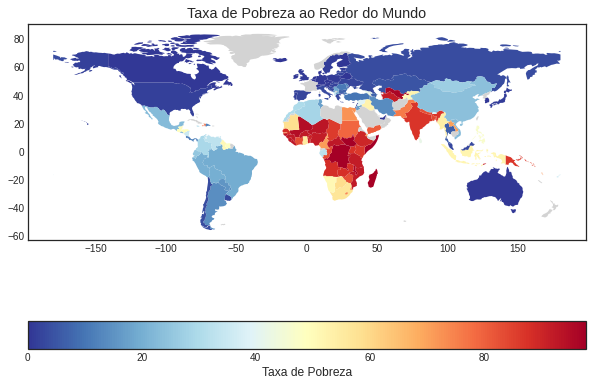

In [35]:
## Bem meljor! mas ainda temos alguns países sem dados no Banco Mundial, e gostaríamos de deixá-los cinzas
## Objeto gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

## Dados
# missing_kwds: argumentos para dados faltantes
dfPaises1.plot(column='Pobreza (%)', 
               ax=ax, 
               legend=True,
               cmap='RdYlBu_r',
               legend_kwds={'label': "Taxa de Pobreza",
                            'orientation': "horizontal"},
               missing_kwds={'color': 'lightgrey'})

## Título
plt.title("Taxa de Pobreza ao Redor do Mundo")

# Limpando mensagens de avisos de erros futuros no pacote
clear_output()

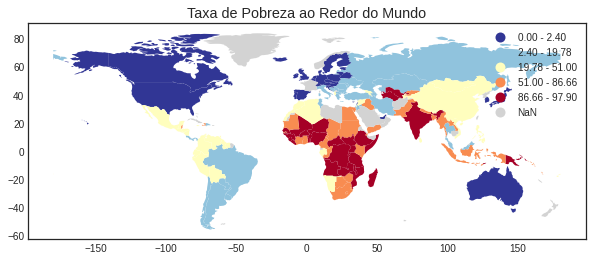

In [36]:
## Por fim, podemos tornar os dados por quintis usando o argumento scheme
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

## Dados
dfPaises1.plot(column='Pobreza (%)', 
               ax=ax,
               scheme='quantiles', 
               legend=True,
               cmap='RdYlBu_r',
               missing_kwds={'color': 'lightgrey'})

## Título
plt.title("Taxa de Pobreza ao Redor do Mundo")

# Limpando mensagens de avisos de erros futuros no pacote
clear_output()

## PIBs Estaduais

In [37]:
## Lendo os dados espaciais de cada estado
# Mais informações sobre o geobr: https://ipeagit.github.io/geobr/articles/python-intro/py-intro-to-geobr.html
gdfEstados = geobr.read_state(year=2019)

/usr/local/lib/python3.7/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/usr/local/lib/python3.7/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



In [38]:
## Lendo a base de dados dos PIBs estaduais de 2018 (em R$ milhões)
# Fonte: https://www.ibge.gov.br/explica/pib.php
dfPIBEstados = pd.read_excel(f"{sCaminho}PIB_Estados_RS_Milhao.xlsx")
dfPIBEstados.head()

,name_state,abbrev_state,pib
0,Acre,AC,15331
1,Alagoas,AL,54413
2,Amapá,AP,16795
3,Amazonas,AM,100109
4,Bahia,BA,286240


In [39]:
## Vamos unir os dois datasets para termos os dados de pobreza
gdfPIBEstados = gdfEstados.merge(dfPIBEstados, on='abbrev_state', how="left")

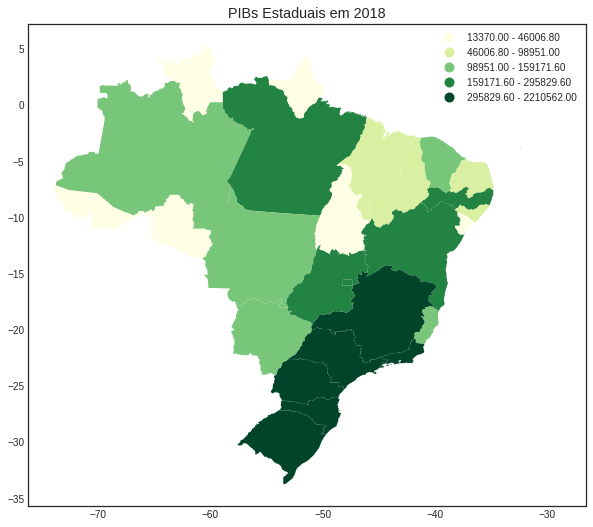

In [40]:
## Objeto gráfico
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

## Dados
gdfPIBEstados.plot(column='pib', 
               ax=ax, 
               legend=True,
               cmap='YlGn',
               scheme='quantiles')

## Título
plt.title("PIBs Estaduais em 2018")

# Limpando mensagens de avisos de erros futuros no pacote
clear_output()

## Desemprego e População Ocupada

### Leitura

In [41]:
## Lendo os dados
# Fonte: SIDRA/IBGE (PNADC/M) (https://sidra.ibge.gov.br/home/pnadcm)
# index_col=0: retorna data como index
dfEmprego = pd.read_excel(f"{sCaminho}populacao_ocupada_taxa_desocupacao.xlsx", index_col=0)
dfEmprego.tail(5)

,ocupados,taxa_desocupacao
data,,
2021-04-01,85940,0.147
2021-05-01,86708,0.146
2021-06-01,87791,0.141
2021-07-01,89042,0.137
2021-08-01,90188,0.132


### Ocupados/Empregados

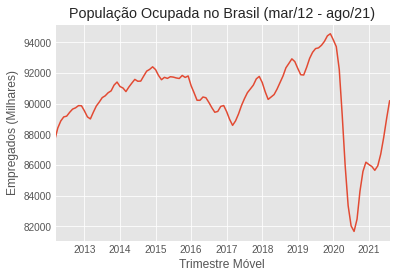

In [42]:
## Plottando os dados
# Estilo
style.use("ggplot")

# Dados
ax = dfEmprego[['ocupados']].plot(legend=None)

# Títulos
plt.xlabel("Trimestre Móvel")
plt.ylabel("Empregados (Milhares)")
plt.title("População Ocupada no Brasil (mar/12 - ago/21)")

plt.show()

## Taxa de Desocupação/Desemprego

Lembrando: taxa de desocupação é popOcupados / Força_Trabalho, onde a força de trabalho é composta pelas pessoas empregadas e aquelas que estão ATIVAMENTE PROCURANDO EMPREGO.

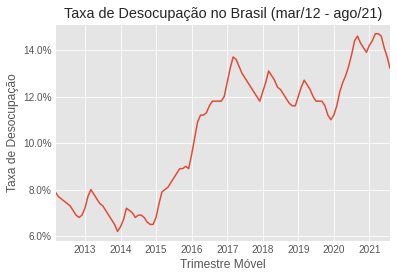

In [43]:
## Plottando os dados
# Estilo
style.use("ggplot")

# Dados
ax = (100 * dfEmprego[['taxa_desocupacao']]).plot(legend=None)

# Títulos
plt.xlabel("Trimestre Móvel")
plt.ylabel("Taxa de Desocupação")
plt.title("Taxa de Desocupação no Brasil (mar/12 - ago/21)")

# Colocando valores do eixo y como percentuais
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

## Duas coisas legais de serem vistas:
  # 1. Como a taxa é bastante sazonal (cresce nos primeiros meses do ano e diminui ao longo dele), assim como é a população empregada
  # 2. Como a queda da população ocupada na pandemia foi MUITO maior que a subida na taxa de desocupação,
  # uma vez que as pessoas que perderam o emprego permaneceram em casa e, consequentemente, não estavam buscando ativamente emprego.

# Obrigado!